In [1]:
using LinearAlgebra
using Dierckx
#using Roots
using NLsolve
using Plots
using DelimitedFiles
#using LaTeXStrings

In [2]:
struct Model{TI<:Integer, TF<:AbstractFloat, TV<:Vector}
    β::TF       # 割引因子
    γ::TF       # 相対的危険回避度
    α::TF       # 資本分配率
    δ::TF       # 固定資本減耗      
    # 定常状態の値
    ykss::TF
    kss::TF
    yss::TF
    css::TF
    nk::TI      # 資本グリッドの個数
    kmax::TF    # 資本グリッドの最大値
    kmin::TF    # 資本グリッドの最小値 (0にすると生産が出来なくなる)
    kgrid::TV   # 資本グリッド
    maxiter::TI # 繰り返し計算の最大値
    tol::TF     # 許容誤差
end

In [3]:
function EulerEq(x,m,capital,cnext)
# cを与えたときのオイラー方程式の残差を返す関数
    
    cons = x[1]
    wealth = capital^m.α + (1-m.δ)*capital
    
    kprime = wealth - cons
    # トリック: k'は正の値しか取らない
    kprime = max(m.kgrid[1],kprime)
    
    # オイラー方程式
    res = mu_CRRA(cons,m.γ) - m.β*mu_CRRA(cnext(kprime),m.γ)*(m.α*kprime.^(m.α-1) + (1-m.δ))

    return res 
end

EulerEq (generic function with 1 method)

In [4]:
function CRRA(cons::Real, gamma)
    """
    Compute CRRA utility function
    
    # Arguments

    - `cons::Real`: consumption value
    - `gamma::Real`: relative risk aversion
    
    # Return 
    - `util::Real`: utility value 
    """
    if gamma != 1.0
        util = cons^(1.0 - gamma) / (1.0 - gamma)
    else
        util = log(cons) 
    end
    return util
end

CRRA (generic function with 1 method)

In [5]:
function mu_CRRA(cons::Real, gamma)
    """
    Compute marginal utility of CRRA-type function
    
    # Arguments 
    - "cons::VecOrMat": consumption value
    - "gamma::Real": relative risk aversion
    
    # Return
    - "mu::Real": marginal utility 
    """
    
    mu = cons^-gamma
    return mu
end

mu_CRRA (generic function with 1 method)

In [6]:
function nti(m::Model)
    
    # *** 収束の基準 ***
    it = 1 # ループ・カウンター
    dif2 = 1.0 # 政策関数の繰り返し誤差
    tolfun = 1e-10 # NLsolveのオプション(最適化の許容誤差)

    println(" ")
    println("-+- Solve a neoclassical growth model with time iteration -+-")
    println(" ")    
    
    ## STEP 1(b): 政策関数の初期値を当て推量    
    # 解析解 (for k'=g(k))
    p_true = m.β*m.α*(m.kgrid.^m.α)
    
    # 政策関数の初期化
    #cfcn0 = m.kgrid
    cfcn0 = m.css/m.kss*m.kgrid
    cfcn1 = zeros(m.nk)
        
    # 繰り返し誤差を保存する変数を設定 
    dif = zeros(2,m.maxiter)
    
    ## STEP 4: 価値関数を繰り返し計算
    while (it < m.maxiter && dif2 > m.tol)
        
        # 次期の政策関数を補間
        # 次期の政策関数を線形補間: m.nk=21のときは政策関数の形がおかしい???
        cnext = Spline1D(m.kgrid,cfcn0,k=1,bc="extrapolate") #線形補間
        # 次期の価値関数をスプライン補間
        #cnext = Spline1D(m.kgrid,cfcn0,k=3,bc="extrapolate") #スプライン補間
        
        for i = 1:m.nk
            
            capital = m.kgrid[i]
            wealth = capital.^m.α + (1-m.δ).*capital
            
            # Juliaの最適化関数(NLsolve or Roots)を使って各グリッド上の政策関数の値を探す
            EulerEq!(x) = EulerEq(x,m,capital,cnext)
            # 最適化の初期値は古い政策関数の値
            # for Roots
#            cons = find_zero(EulerEq!,cfcn0[i])            
#            cfcn1[i] = cons
            # for NLsolve
            sol = nlsolve(EulerEq!,[cfcn0[i]],ftol=tolfun)
            cfcn1[i] = sol.zero[1]
            # グリッドごとに最適化の結果を確認
            #disp([cons capital wealth kprime]);
            #pause

        end
        
        # 繰り返し計算誤差を確認
        dif2 = maximum(abs.(cfcn1-cfcn0)) # 政策関数の繰り返し計算誤差(図示のため)
        
        println([it dif2])
        
        # 収束途中の繰り返し計算誤差を保存
        dif[2,it] = dif2
        
        # 政策関数をアップデート
        cfcn0 = copy(cfcn1)
        
        it = it + 1
        
    end
        
    return cfcn0, dif 
end

nti (generic function with 1 method)

In [7]:
# カリブレーション
β = 0.96 # 割引因子
γ = 1.0  # 相対的危険回避度(異時点間の代替の弾力性の逆数)
α = 0.40 # 資本分配率
δ = 1.0  # 固定資本減耗(delta=1.0のときは解析解が存在)

# 定常状態の値
ykss = (1/β-1+δ)/α
kss = ykss^(1/(α-1))
yss = ykss*kss
css = yss-δ*kss

kmax = 0.5  # 資本グリッドの最大値
kmin = 0.05 # 資本グリッドの最小値 (0にすると生産が出来なくなる)
#========================#

## STEP 1(a): グリッド生成
nk = 21     # グリッドの数
kgrid = collect(LinRange(kmin,kmax,nk))

maxiter = 1000 # 繰り返し回数の最大値
tol = 1.0e-5   # 許容誤差(STEP 2)

m = Model(β,γ,α,δ,ykss,kss,yss,css,nk,kmax,kmin,kgrid,maxiter,tol)

Model{Int64,Float64,Array{Float64,1}}(0.96, 1.0, 0.4, 1.0, 2.6041666666666665, 0.20287041017208587, 0.5283083598231403, 0.32543794965105444, 21, 0.5, 0.05, [0.05, 0.0725, 0.095, 0.1175, 0.14, 0.1625, 0.185, 0.2075, 0.23, 0.2525  …  0.2975, 0.32, 0.3425, 0.365, 0.3875, 0.41, 0.4325, 0.455, 0.4775, 0.5], 1000, 1.0e-5)

In [8]:
@time cfcn0, dif = nti(m)

 
-+- Solve a neoclassical growth model with time iteration -+-
 
[1.0 0.307689]
[2.0 0.0235064]
[3.0 0.00345573]
[4.0 0.000539147]
[5.0 8.43125e-5]
[6.0 1.34263e-5]
[7.0 2.23375e-6]
  5.222965 seconds (16.06 M allocations: 784.116 MiB, 6.48% gc time)


([0.185823, 0.215562, 0.240176, 0.261559, 0.280493, 0.297769, 0.313586, 0.328353, 0.342145, 0.355152  …  0.37924, 0.390457, 0.401239, 0.411577, 0.421535, 0.431172, 0.440516, 0.449519, 0.458271, 0.466793], [0.0 0.0 … 0.0 0.0; 0.307689 0.0235064 … 0.0 0.0])

In [9]:
## 最終的な政策関数が得られてから貯蓄関数を計算
pfcn0 = m.kgrid.^(m.α) + (1-m.δ).*m.kgrid - cfcn0;

In [10]:
## 解析的解
p_true = m.β*m.α*(m.kgrid.^m.α);

In [11]:
## オイラー方程式から誤差を測定
# 元のグリッドではオイラー方程式の誤差はゼロになるため、グリッドを細かくとる
kgrid_err = collect(LinRange(kmin,kmax,(nk-1)*10+1))
cons_interp = Spline1D(m.kgrid,cfcn0,k=1,bc="extrapolate")
cons = cons_interp(kgrid_err)
LHS  = mu_CRRA.(cons,m.γ)

kp   = kgrid_err.^m.α + (1-m.δ)*kgrid_err - cons
cnext = cons_interp(kp)
rent = m.α.*kp.^(m.α-1.0) .- m.δ
RHS  = m.β.*(1 .+ rent).*mu_CRRA.(cnext,m.γ)

err  = RHS./LHS.-1.0;

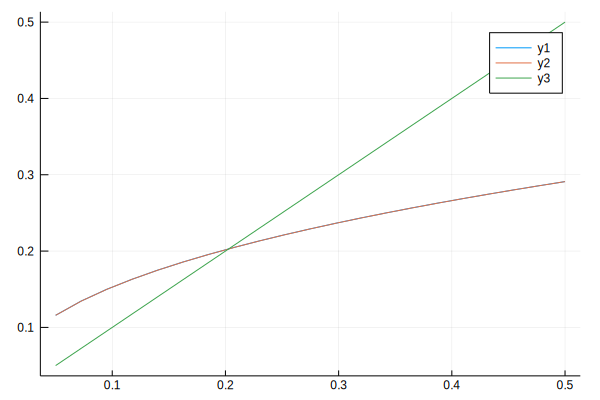

In [12]:
plot(m.kgrid,pfcn0)
plot!(m.kgrid,p_true)
plot!(m.kgrid,m.kgrid)

In [16]:
err2 = readdlm("err_ndp.csv")
err2 = vec(err2);

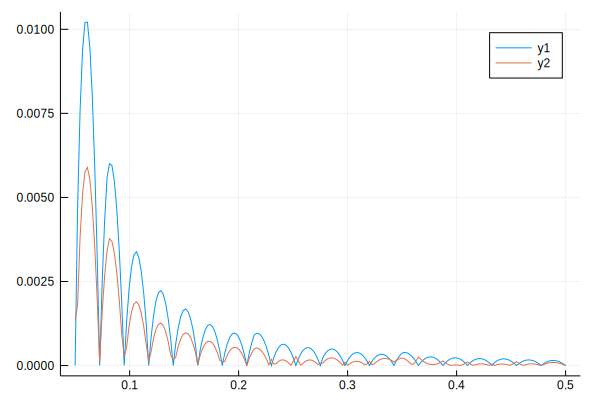

In [18]:
plot(kgrid_err,abs.(err))
plot!(kgrid_err,abs.(err2))